In this notebook, we are going to fine-tune `LayoutLMv3ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv3 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv3 model very powerful for document understanding tasks.


* Paper: https://arxiv.org/abs/2204.08387
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv3

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv3. For that, check out the notebook "Prepare CORD for LayoutLMv3".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!rm -r transformers
!git clone -b add_layoutlmv3 https://github.com/NielsRogge/transformers
!cd transformers
!pip install -q ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 128123, done.
remote: Total 128123 (delta 0), reused 0 (delta 0), pack-reused 128123
Receiving objects: 100% (128123/128123), 106.36 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (94039/94039), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
!pip install -q datasets seqeval

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).



## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [5]:
from collections import Counter
import pandas as pd

In [6]:
!pip install gradio
!pip install pytesseract
!pip install tesseract
!pip install tesseract-ocr
import pytesseract

# Define Paths
poppler_path = r'C:\Program Files\poppler-0.68.0\bin'
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

!sudo apt install tesseract-ocr
!pip install pytesseract
# !sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tesseract-ocr-0.0.1.tar.gz (33 kB)
  ERROR: Failed building wheel for tesseract-ocr
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
    Running setup.py install for tesseract-ocr ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-tkhkhrkt/tesseract-ocr_487372da109e47bab90aaefa7e0b32f0/setup.py'"'"'; __file__='"'"'/tmp/pip-install-tkhkhrkt/tesseract-ocr_487372da109e47bab90aaefa7e0b32f0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) 

In [7]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
train = pd.read_pickle('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/train.pkl')
val = pd.read_pickle('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/val.pkl')
test = pd.read_pickle('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [9]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [10]:
replacing_labels = {'others': 'O', 'mneu.itemsubtotal': 'O', 'menu.sub_etc': 'O', 'menu.sub_unitprice': 'O', 'menu.vatyn': 'O',
                  'void_menu.nm': 'O', 'void_menu.price': 'O', 'sub_total.othersvc_price': 'O'}

In [11]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]
train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]

In [12]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'O': 10,
         'cer': 13,
         'datarichiesta': 10,
         'orariorichiesta': 10,
         'produttore': 10,
         'unitloc': 10})

In [13]:
labels = list(set(all_labels))
print(labels)

['datarichiesta', 'orariorichiesta', 'produttore', 'O', 'unitloc', 'cer']


In [14]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'datarichiesta': 0, 'orariorichiesta': 1, 'produttore': 2, 'O': 3, 'unitloc': 4, 'cer': 5}
{0: 'datarichiesta', 1: 'orariorichiesta', 2: 'produttore', 3: 'O', 4: 'unitloc', 5: 'cer'}


In [15]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=256):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes, self.image_file_names = annotations
        self.image_dir = image_dir
        #self.image_file_names = [(image_dir + "/" + f) for f in annotations[3]]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        # assert encoded_inputs.input_ids.shape == torch.Size([512])
        # assert encoded_inputs.attention_mask.shape == torch.Size([512])
        # assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        # assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        # assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        # assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [16]:
from transformers import LayoutLMv3Processor, LayoutLMv3TokenizerFast, LayoutLMv3FeatureExtractor, LayoutLMv3ForTokenClassification

tokenizer = LayoutLMv3TokenizerFast.from_pretrained('microsoft/layoutlmv3-base')
processor = LayoutLMv3Processor(LayoutLMv3FeatureExtractor(apply_ocr=False), tokenizer)

In [17]:


train_dataset = CORDDataset(annotations=train,
                            image_dir='/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/images/train/', 
                            processor=processor)
val_dataset = CORDDataset(annotations=val,
                            image_dir='/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/images/val/', 
                            processor=processor)
test_dataset = CORDDataset(annotations=test,
                            image_dir='/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/images/test/', 
                            processor=processor)

In [18]:
encoding = train_dataset[0]

In [19]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [21]:
model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=len(labels))

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import AdamW
import torch
from tqdm.notebook import tqdm as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 100 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

model.save_pretrained("/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/Models/")

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Loss after 0 steps: 1.899239182472229
Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [23]:
test

[[['COMUNE DI PISTOIA',
   'Via Dino Buzzati, 1 51100 PISTOIA (PT)',
   '25/02/2022',
   '08:00',
   '170201',
   'SCHEDA FATTA DA MATILDE CHIAMARE ALMENO DUE GIORNI PRIMA PER CONFERMA DATA E ORARIO DAL LUNEDì AL VENERDì 08:00 13:00 MARTEDì E GIOVEDì 14:30 17:00 CAMBIO CASSONE DA 30MChttps://www.google.com/maps/@43.9305451,10.9433864,3a,75y ,179.63h,86.79t/data=!3m6!1e1!3m4! 1sqBwGa7tckBjoehYHEWaJdg!2e0!7i16384!8i8192']],
 [['produttore', 'unitloc', 'datarichiesta', 'orariorichiesta', 'cer', 'O']],
 [[[162, 159, 308, 171],
   [161, 194, 428, 207],
   [172, 276, 260, 287],
   [431, 274, 480, 286],
   [58, 572, 118, 591],
   [518, 347, 980, 481]]],
 ['10.jpg']]

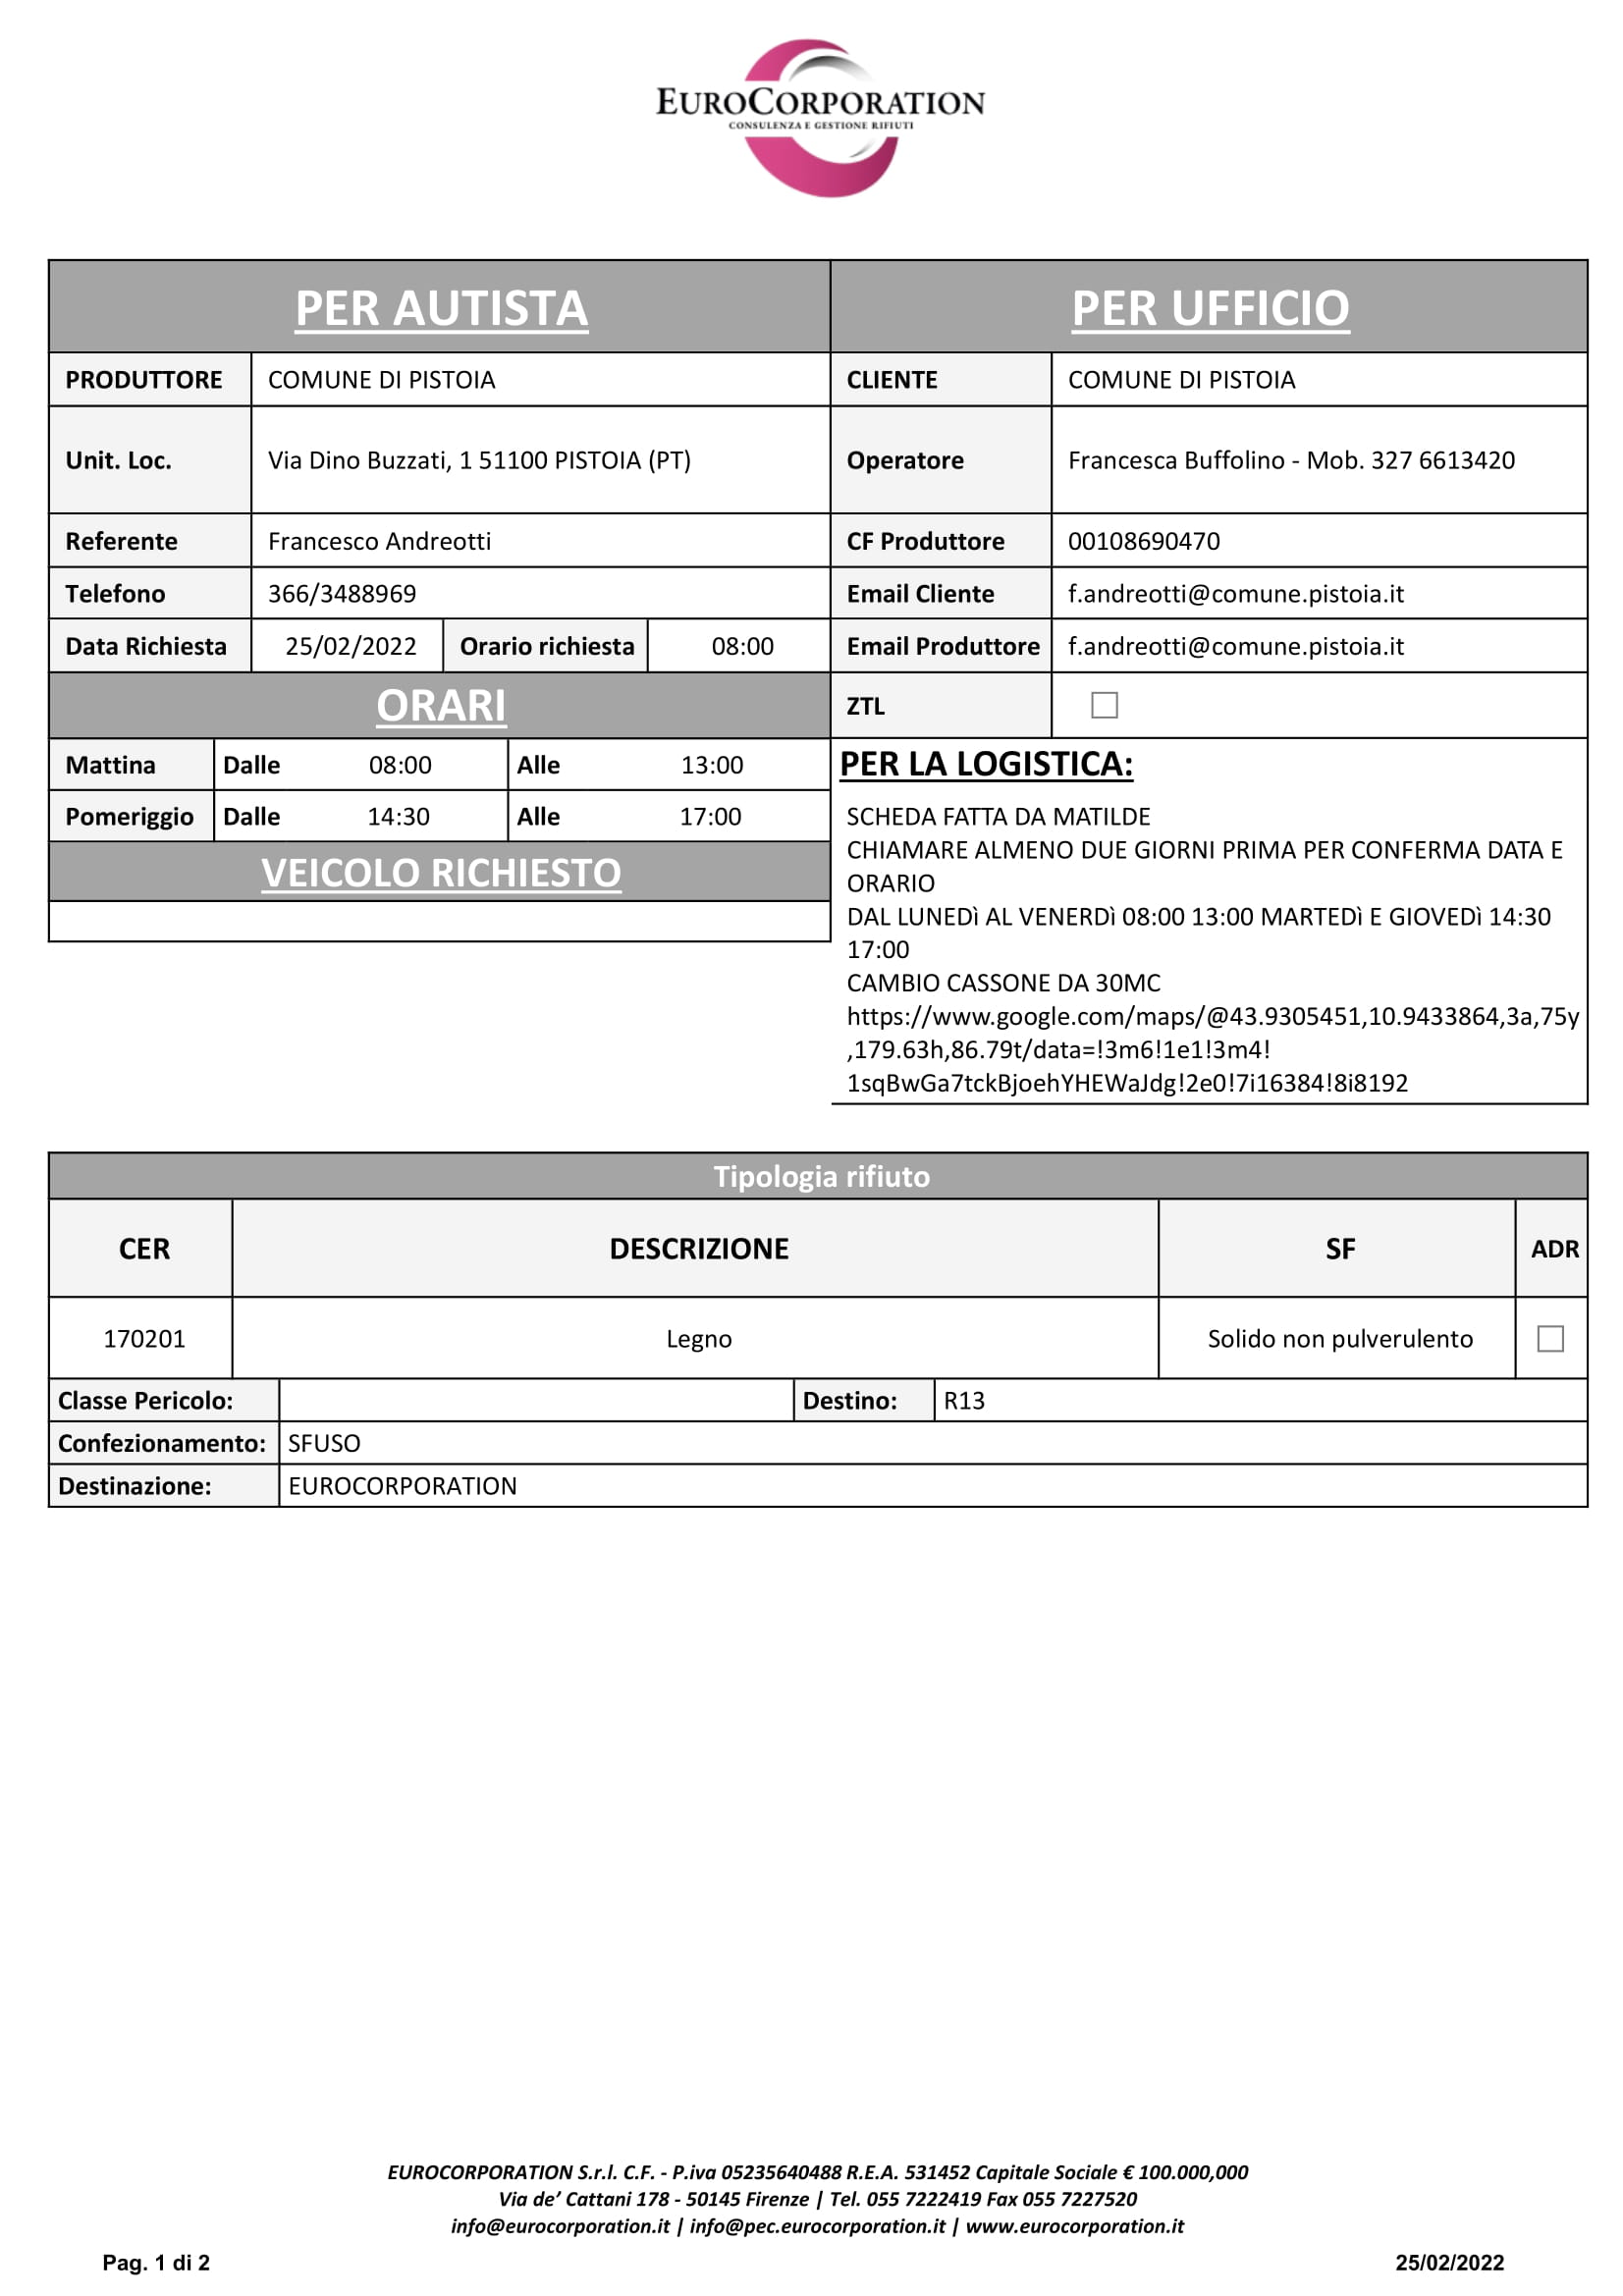

In [24]:
img = Image.open("/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/images/test/"+ test[3][0])
img

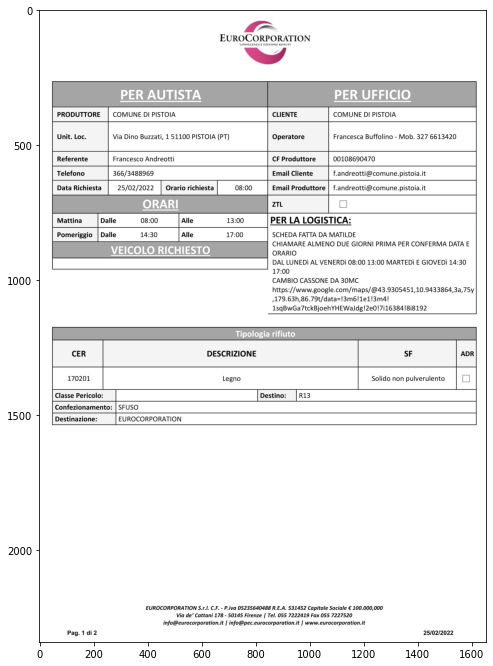

In [25]:
import matplotlib.pyplot as plt


# Load image from local storage
img = Image.open("/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/images/test/"+ test[3][0])
plt.figure(figsize = (8, 12))
plt.imshow(img, cmap='gray')

In [26]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'],
                attention_mask=encoding['attention_mask'],
                bbox=encoding['bbox'],
                pixel_values=encoding['pixel_values'])

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [27]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [28]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['produttore', 'unitloc', 'datarichiesta', 'orariorichiesta', 'cer', 'O']


In [29]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
def evaluate(dataloader):
  preds_val = None
  out_label_ids = None
  for batch in tqdm(dataloader, desc="Evaluating"):
      with torch.no_grad():
          input_ids = batch['input_ids'].to(device)
          bbox = batch['bbox'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          pixel_values = batch['pixel_values'].to(device)
          labels = batch['labels'].to(device)

          # forward pass
          outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, 
                          pixel_values=pixel_values, labels=labels)
          
          if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
          else:
            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
            )
  return preds_val, out_label_ids

In [30]:
preds_val, out_label_ids = evaluate(test_dataloader)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [31]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [32]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
                precision    recall  f1-score   support

  atarichiesta       1.00      1.00      1.00         1
            er       1.00      1.00      1.00         1
        nitloc       1.00      1.00      1.00         1
rariorichiesta       1.00      1.00      1.00         1
     roduttore       1.00      1.00      1.00         1

     micro avg       1.00      1.00      1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



In [33]:
preds_val, out_label_ids = evaluate(val_dataloader)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
                precision    recall  f1-score   support

  atarichiesta       1.00      1.00      1.00         2
            er       1.00      1.00      1.00         2
        nitloc       1.00      1.00      1.00         2
rariorichiesta       1.00      1.00      1.00         2
     roduttore       1.00      1.00      1.00         2

     micro avg       1.00      1.00      1.00        10
     macro avg       1.00      1.00      1.00        10
  weighted avg       1.00      1.00      1.00        10



id2label {0: 'datarichiesta', 1: 'orariorichiesta', 2: 'produttore', 3: 'O', 4: 'unitloc', 5: 'cer'}
<class 'PIL.Image.Image'>
[('produttore', 'produttore', [0.0, 0.0, 0.0, 0.0], 'blue'), ('produttore', 'produttore', [758.727, 39.763000000000005, 869.4780000000001, 81.86500000000001], 'blue'), ('produttore', 'produttore', [667.812, 88.88199999999999, 1001.718, 116.95], 'blue'), ('unitloc', 'unitloc', [740.544, 123.967, 814.929, 130.984], 'purple'), ('unitloc', 'unitloc', [819.888, 123.967, 824.847, 130.984], 'purple'), ('unitloc', 'unitloc', [828.153, 123.967, 881.0490000000001, 130.984], 'purple'), ('unitloc', 'unitloc', [887.6610000000001, 123.967, 928.9860000000001, 130.984], 'purple'), ('unitloc', 'unitloc', [1094.286, 294.714, 1176.936, 329.799], 'purple'), ('unitloc', 'unitloc', [1195.119, 294.714, 1373.643, 329.799], 'purple'), ('unitloc', 'unitloc', [1087.674, 376.579, 1178.589, 395.29100000000005], 'purple'), ('unitloc', 'unitloc', [1181.895, 376.579, 1216.608, 395.29100000000

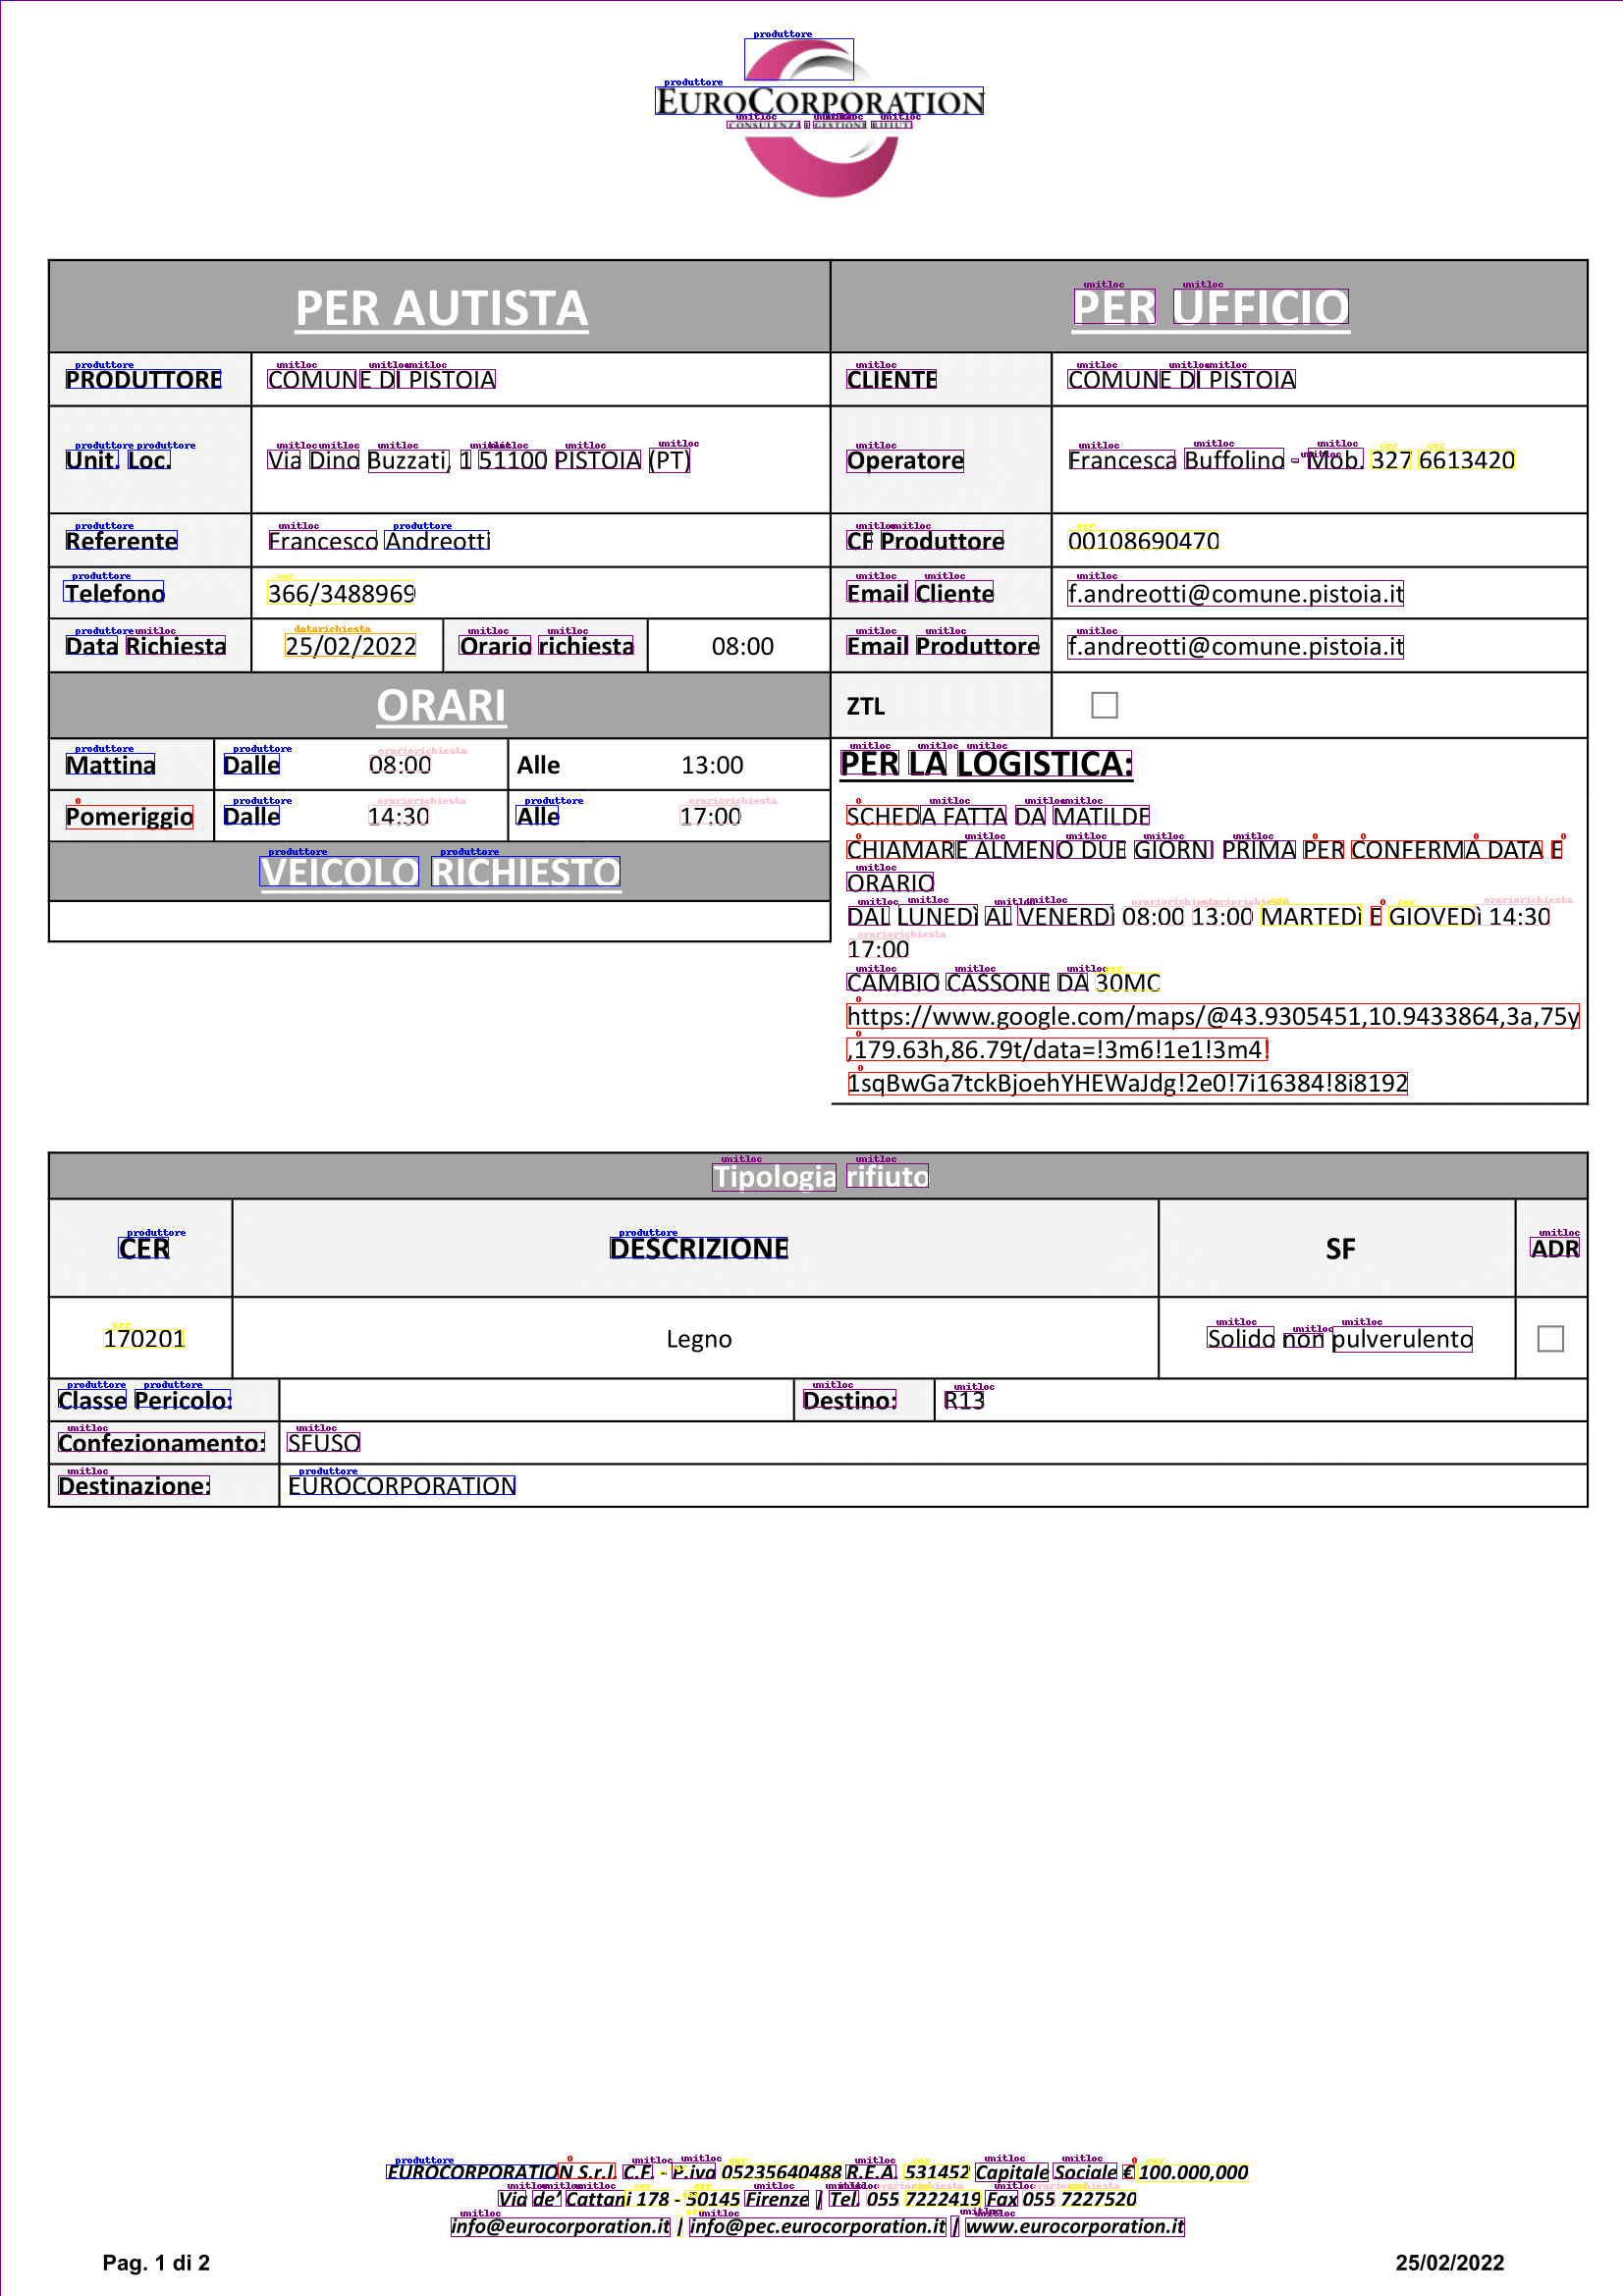

In [46]:
import os

import gradio as gr
import numpy as np
from transformers import AutoModelForTokenClassification
from datasets.features import ClassLabel
from transformers import AutoProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
from datasets import load_metric
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator


from transformers import AutoModelForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont


processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)
model = AutoModelForTokenClassification.from_pretrained("/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/Models/")



# load image example
# dataset = load_dataset("Theivaprakasham/wildreceipt", split="test")
# Image.open(dataset[20]["image_path"]).convert("RGB").save("example1.png")
# Image.open(dataset[13]["image_path"]).convert("RGB").save("example2.png")
# Image.open(dataset[15]["image_path"]).convert("RGB").save("example3.png")
# define id2label, label2color
# labels = dataset.features['ner_tags'].feature.names
#{'O': 0, 'produttore': 1, 'datarichiesta': 2, 'cer': 3, 'orariorichiesta': 4, 'unitloc': 5}


id2label = {v: k for v, k in enumerate(labels)}
print('id2label',id2label)
label2color = {
    "O": 'red',
    "produttore": 'blue',
    "datarichiesta": 'orange',
    "cer": 'yellow',
    "orariorichiesta": 'pink',
    'unitloc': "purple"
  }

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(image):

    print(type(image))
    width, height = image.size

    # encode
    encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    # draw predictions over the image
    layout_details = []
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        layout_details.append((predicted_label, prediction, box, label2color[predicted_label]))
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    print(layout_details)
    # for i, j in zip(words[0], layout_details[1:-1]):
    #   print(j[0],i)     
    return image


from PIL import Image, ImageDraw, ImageFont
image = Image.open('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/layoutLMV2 -CORD/11.png')
image = image.convert("RGB")
process_image(image)
